# IMPORTING ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

# LOAD DATASET

In [2]:
data = pd.read_csv("data.csv")
data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


# EXPLORATORY DATA ANALYSIS AND VISUALIZATION

In [39]:
# data size

data.shape

(1490, 4)

In [4]:
# information about data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [5]:
data['Category'].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [6]:
data.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [7]:
# Associate Category names with numerical index and save it in new column CategoryId

target_category = data['Category'].unique()
target_category

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [8]:
data['CategoryId'] = data['Category'].factorize()[0]
data.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [9]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values

category = data[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


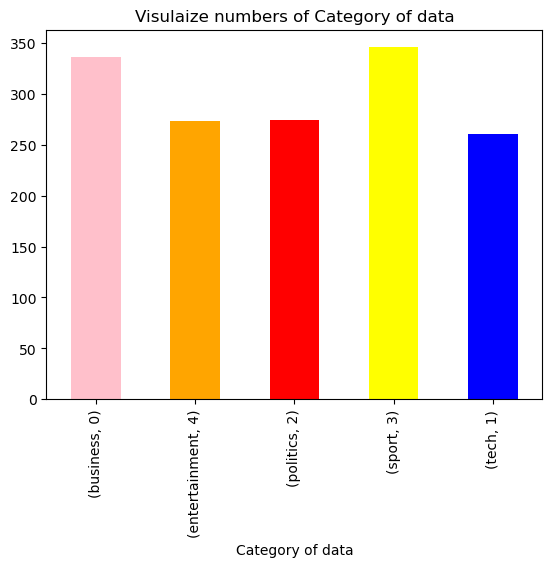

In [10]:
#visualizing category data in numeric form

data.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

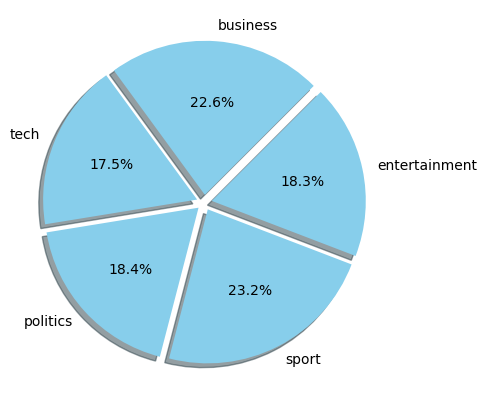

In [11]:
# visualizing category data in percentage form

fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
business = data[data['CategoryId'] == 0 ]
tech = data[data['CategoryId'] == 1 ]
politics = data[data['CategoryId'] == 2]
sport = data[data['CategoryId'] == 3]
entertainment = data[data['CategoryId'] == 4]
count = [business['CategoryId'].count(), tech['CategoryId'].count(), politics['CategoryId'].count(), sport['CategoryId'].count(), entertainment['CategoryId'].count()]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05))

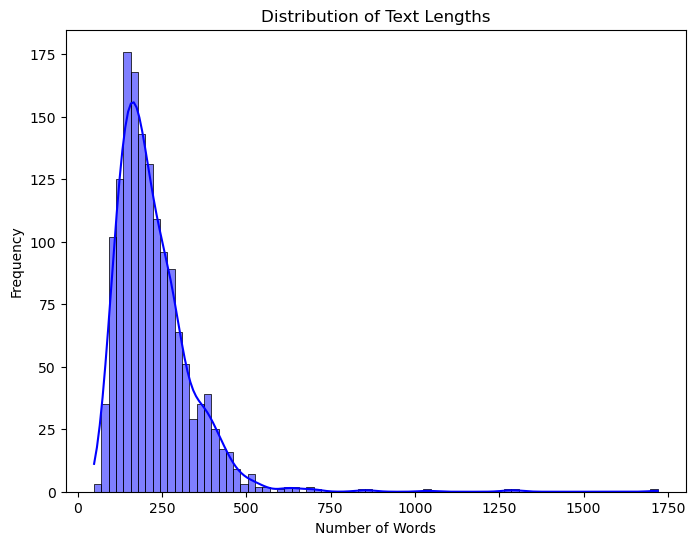

In [40]:
data['Text_Length'] = data['Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.histplot(data['Text_Length'], kde=True, color='blue')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [41]:
category_counts = data['Category'].value_counts(normalize=True)
print("Category Proportions:\n", category_counts)

Category Proportions:
 Category
sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: proportion, dtype: float64


business related words:


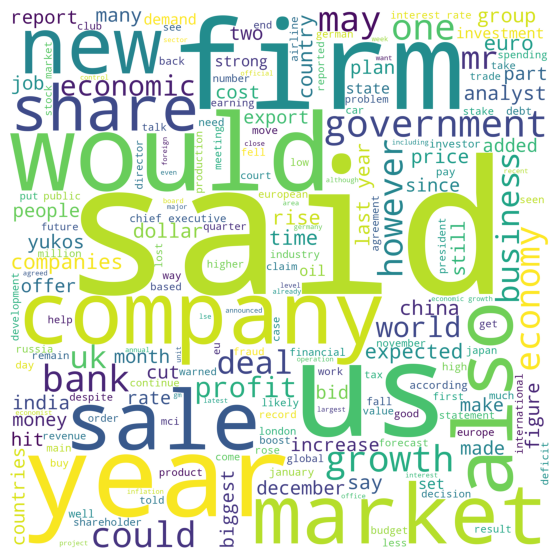

tech related words:


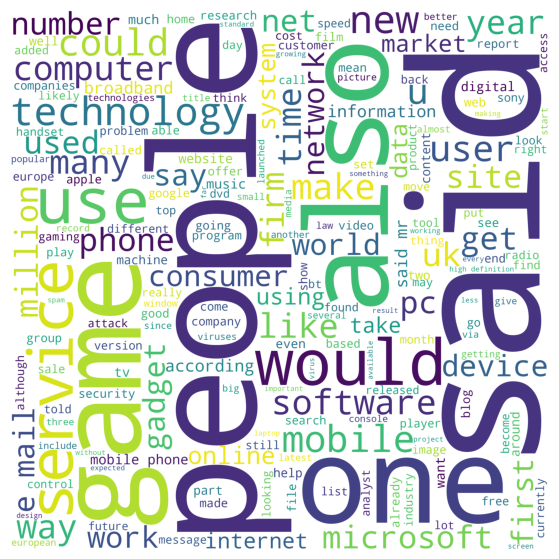

politics related words:


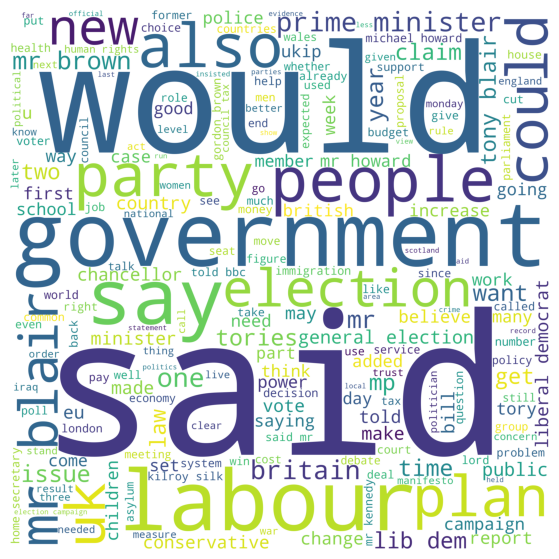

sport related words:


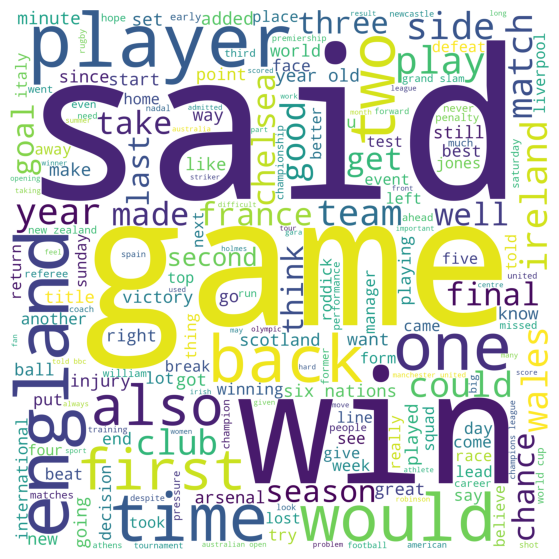

entertainment related words:


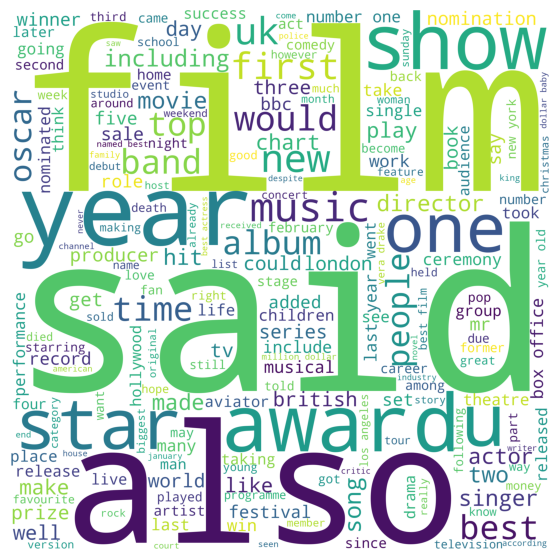

In [12]:
# visualizing category related words

from wordcloud import WordCloud
stop = set(stopwords.words('english'))

business = data[data['CategoryId'] == 0]
business = business['Text']

tech = data[data['CategoryId'] == 1]
tech = tech['Text']

politics = data[data['CategoryId'] == 2]
politics = politics['Text']

sport = data[data['CategoryId'] == 3]
sport = sport['Text']

entertainment = data[data['CategoryId'] == 4]
entertainment = entertainment['Text']


def wordcloud_draw(data, color = 'white'):
  words = ' '.join(data)
  cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

print("business related words:")
wordcloud_draw(business, 'white')

print("tech related words:")
wordcloud_draw(tech, 'white')

print("politics related words:")
wordcloud_draw(politics, 'white')

print("sport related words:")
wordcloud_draw(sport, 'white')

print("entertainment related words:")
wordcloud_draw(entertainment, 'white')

# DATA PREPROCESSING

In [13]:
text = data["Text"]
text.head(10)

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
5    howard  truanted to play snooker  conservative...
6    wales silent on grand slam talk rhys williams ...
7    french honour for director parker british film...
8    car giant hit by mercedes slump a slump in pro...
9    fockers fuel festive film chart comedy meet th...
Name: Text, dtype: object

In [14]:
category = data['Category']
category.head(10)

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object

## Removing all tags

In [15]:
def remove_tags(text):
  remove = re.compile(r'')
  return re.sub(remove, '', text)
data['Text'] = data['Text'].apply(remove_tags)
data['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

## removing special characters

In [16]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews
data['Text'] = data['Text'].apply(special_char)
data['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

## Converting everything into lower case

In [17]:
def convert_lower(text):
   return text.lower()
data['Text'] = data['Text'].apply(convert_lower)
data['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

## removing all stopwords

In [18]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]
data['Text'] = data['Text'].apply(remove_stopwords)
data['Text'][1]

['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'february',
 'knocking',
 'hopes',
 'speedy',
 'recovery',
 'europe',
 'largest',
 'economy',
 'munich',
 'based',
 'research',
 'institute',
 'ifo',
 'said',
 'confidence',
 'index',
 'fell',
 '95',
 '5',
 'february',
 '97',
 '5',
 'january',
 'first',
 'decline',
 'three',
 'months',
 'study',
 'found',
 'outlook',
 'manufacturing',
 'retail',
 'sectors',
 'worsened',
 'observers',
 'hoping',
 'confident',
 'business',
 'sector',
 'would',
 'signal',
 'economic',
 'activity',
 'picking',
 'surprised',
 'ifo',
 'index',
 'taken',
 'knock',
 'said',
 'dz',
 'bank',
 'economist',
 'bernd',
 'weidensteiner',
 'main',
 'reason',
 'probably',
 'domestic',
 'economy',
 'still',
 'weak',
 'particularly',
 'retail',
 'trade',
 'economy',
 'labour',
 'minister',
 'wolfgang',
 'clement',
 'called',
 'dip',
 'february',
 'ifo',
 'confidence',
 'figure',
 'mild',
 'decline',
 'said',
 'despite',
 'r

## lemmatizing the words

In [19]:
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])
data['Text'] = data['Text'].apply(lemmatize_word)
data['Text'][1]

'german business confidence slide german business confidence fell february knocking hope speedy recovery europe largest economy munich based research institute ifo said confidence index fell 95 5 february 97 5 january first decline three month study found outlook manufacturing retail sector worsened observer hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew 1 6 last year shrinking 2003 however economy contracted 0 2 last three month 2004 mainly due reluctance consumer spend latest indication growth still proving elusive ifo president han werner sinn said improvement german domestic demand sluggish export

In [20]:
# after text pre-processing

data 

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex bos launch defence lawyer defendin...,business,0
1,154,german business confidence slide german busine...,business,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron boss 168m payout eighteen former enron d...,business,0
...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,4
1487,1590,weak dollar hit reuters revenue medium group r...,business,0
1488,1587,apple ipod family expands market apple expande...,tech,1


In [21]:
# declaring dependent and independant variable

X = data['Text']
Y = data['Category']

In [22]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
TfIdf_Vectorizer = TfidfVectorizer(tokenizer = token.tokenize)

A = TfIdf_Vectorizer.fit_transform(X)
array = A.toarray()
pd.DataFrame(data=array, columns = TfIdf_Vectorizer.get_feature_names_out()).head()

C:\Users\Bhoomika Jain\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,0,00,000,0001,000bn,000m,000th,001,001and,001st,...,zombie,zone,zonealarm,zoom,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0433,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,0.0,0.02308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,0.0,0.01815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
array.shape

(1490, 22067)

In [24]:
Y.shape

(1490,)

## splitting the data into training and testing 

In [25]:
x_train, x_test, y_train, y_test = train_test_split(A, Y, test_size = 0.3, random_state = 0, shuffle = True)

In [26]:
def plot_matrix(y_test, y_pred, color="Oranges"):
    labels = np.unique(y_pred)
    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

               precision    recall  f1-score   support

     business       0.95      0.98      0.97       103
entertainment       1.00      1.00      1.00        89
     politics       1.00      0.91      0.95        81
        sport       0.95      1.00      0.97        97
         tech       0.99      0.97      0.98        77

     accuracy                           0.98       447
    macro avg       0.98      0.97      0.98       447
 weighted avg       0.98      0.98      0.98       447



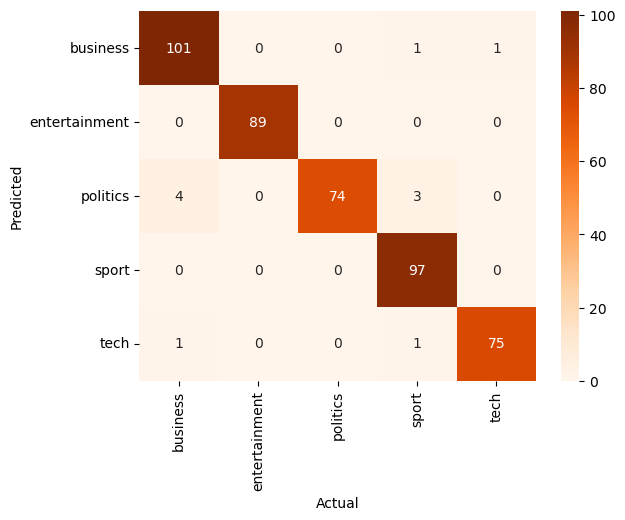

Accuracy : 0.9753914988814317


In [27]:
# Logistic Regression

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

print(classification_report(y_test, y_pred))

plot_matrix(y_test, y_pred)

print("Accuracy :",accuracy_score(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.96      0.99      0.98       103
entertainment       0.99      1.00      0.99        89
     politics       1.00      0.94      0.97        81
        sport       0.99      1.00      0.99        97
         tech       0.99      0.99      0.99        77

     accuracy                           0.98       447
    macro avg       0.99      0.98      0.98       447
 weighted avg       0.98      0.98      0.98       447



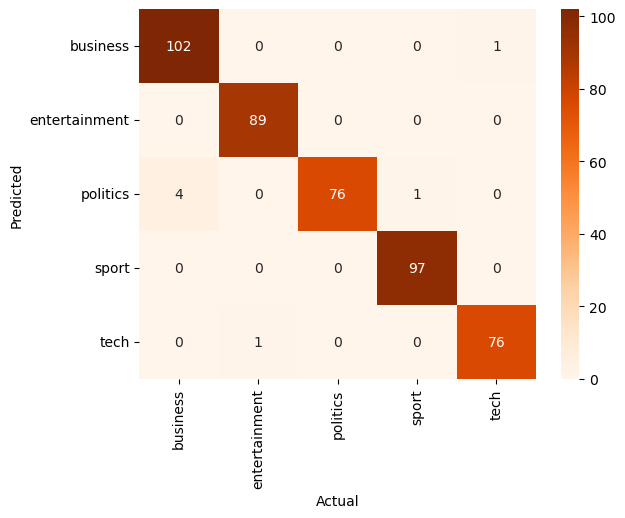

Accuracy : 0.9843400447427293


In [28]:
# support vector machine

svc_linear = svm.SVC(kernel ='linear', C = 1)
svc_linear.fit(x_train, y_train)

y_pred2 = svc_linear.predict(x_test)

print(classification_report(y_test, y_pred2))

plot_matrix(y_test, y_pred2)

print("Accuracy :",accuracy_score(y_test, y_pred2))

               precision    recall  f1-score   support

     business       0.96      0.99      0.98       103
entertainment       1.00      0.94      0.97        89
     politics       0.96      0.93      0.94        81
        sport       0.89      0.99      0.94        97
         tech       1.00      0.92      0.96        77

     accuracy                           0.96       447
    macro avg       0.96      0.95      0.96       447
 weighted avg       0.96      0.96      0.96       447



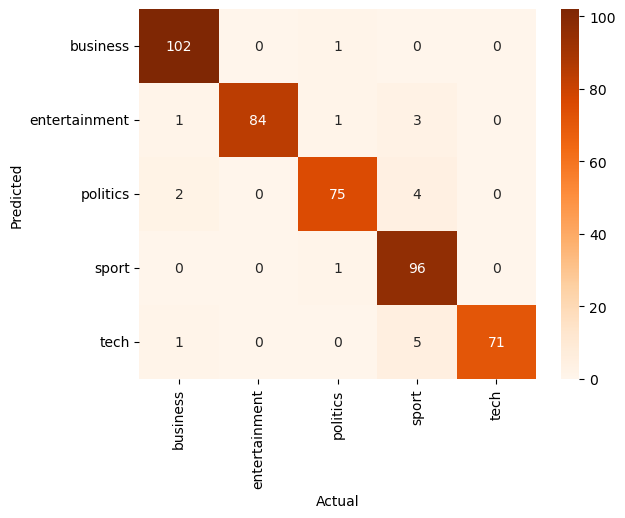

Accuracy : 0.9574944071588367


In [29]:
# random forest classifier

rfc1 = RandomForestClassifier(max_depth=10, random_state=18)
rfc1.fit(x_train, y_train)

y_pred3 = rfc1.predict(x_test)

print(classification_report(y_test, y_pred3))

plot_matrix(y_test, y_pred3)

print("Accuracy :",accuracy_score(y_test, y_pred3))

               precision    recall  f1-score   support

     business       0.88      0.92      0.90       103
entertainment       0.95      0.94      0.95        89
     politics       0.88      0.91      0.90        81
        sport       0.99      0.96      0.97        97
         tech       0.95      0.90      0.92        77

     accuracy                           0.93       447
    macro avg       0.93      0.93      0.93       447
 weighted avg       0.93      0.93      0.93       447



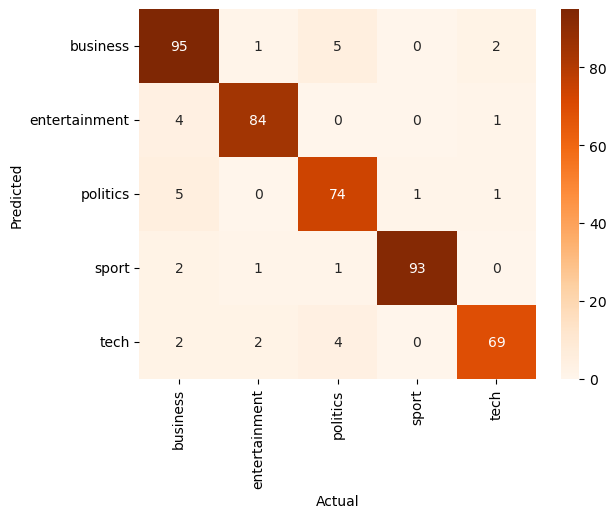

Accuracy : 0.9284116331096197


In [30]:
# knn

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)

y_pred4 = knn.predict(x_test)

print(classification_report(y_test, y_pred4))

plot_matrix(y_test, y_pred4)

print("Accuracy :",accuracy_score(y_test, y_pred4))

               precision    recall  f1-score   support

     business       0.91      0.79      0.84       103
entertainment       0.92      0.91      0.92        89
     politics       0.82      0.86      0.84        81
        sport       0.96      0.97      0.96        97
         tech       0.83      0.94      0.88        77

     accuracy                           0.89       447
    macro avg       0.89      0.89      0.89       447
 weighted avg       0.89      0.89      0.89       447



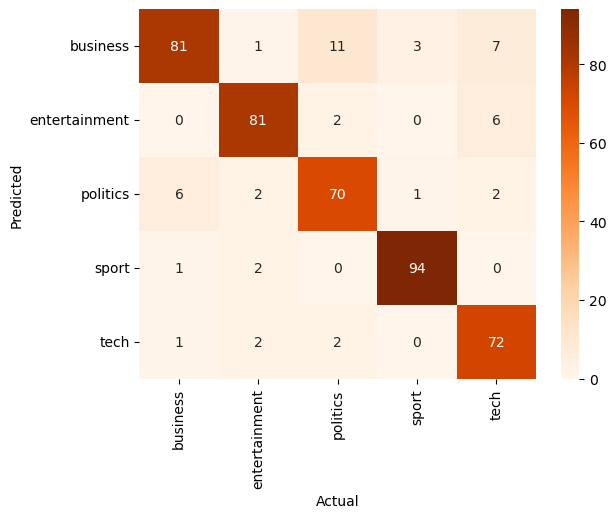

Accuracy : 0.8903803131991052


In [31]:
# Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(x_train.toarray(), y_train)

y_pred5 = gnb.predict(x_test.toarray())

print(classification_report(y_test, y_pred5))

plot_matrix(y_test, y_pred5)

print("Accuracy :",accuracy_score(y_test, y_pred5))

               precision    recall  f1-score   support

     business       0.98      0.98      0.98       103
entertainment       1.00      0.96      0.98        89
     politics       0.97      0.95      0.96        81
        sport       0.94      1.00      0.97        97
         tech       0.96      0.96      0.96        77

     accuracy                           0.97       447
    macro avg       0.97      0.97      0.97       447
 weighted avg       0.97      0.97      0.97       447



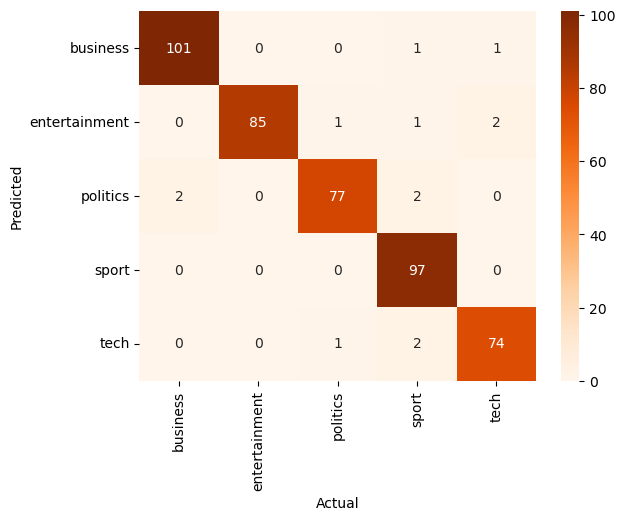

Accuracy : 0.970917225950783


In [32]:
# Multinomial Naive Bayes

mnb = MultinomialNB()
mnb.fit(x_train.toarray(), y_train)

y_pred6 = mnb.predict(x_test.toarray())

print(classification_report(y_test, y_pred6))

plot_matrix(y_test, y_pred6)

print("Accuracy :",accuracy_score(y_test, y_pred6))

               precision    recall  f1-score   support

     business       0.85      1.00      0.92       103
entertainment       0.96      0.96      0.96        89
     politics       0.99      0.88      0.93        81
        sport       0.98      1.00      0.99        97
         tech       0.98      0.84      0.91        77

     accuracy                           0.94       447
    macro avg       0.95      0.94      0.94       447
 weighted avg       0.95      0.94      0.94       447



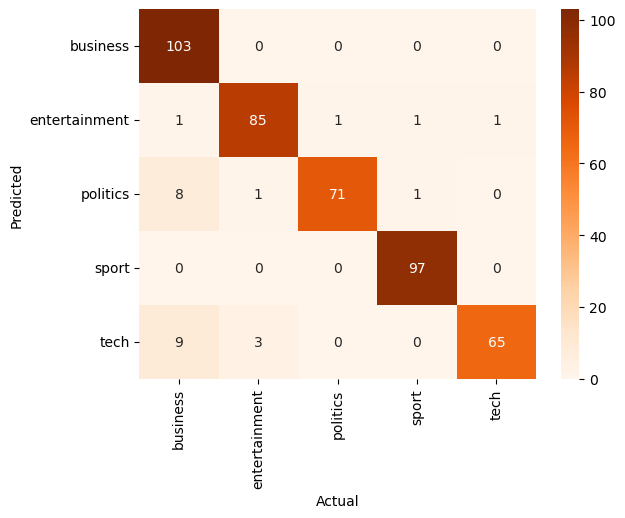

Accuracy : 0.941834451901566


In [33]:
# Bernoulli Naive Bayes

bnb = BernoulliNB()
bnb.fit(x_train, y_train)

y_pred7 = bnb.predict(x_test)

print(classification_report(y_test, y_pred7))

plot_matrix(y_test, y_pred7)

print("Accuracy :",accuracy_score(y_test, y_pred7))

               precision    recall  f1-score   support

     business       0.85      1.00      0.92       103
entertainment       0.96      0.96      0.96        89
     politics       0.99      0.88      0.93        81
        sport       0.98      1.00      0.99        97
         tech       0.98      0.84      0.91        77

     accuracy                           0.94       447
    macro avg       0.95      0.94      0.94       447
 weighted avg       0.95      0.94      0.94       447



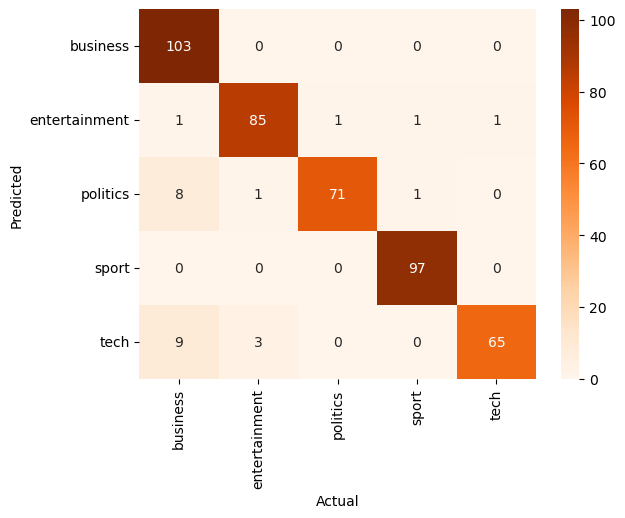

Accuracy : 0.941834451901566


In [34]:
# decision tree classifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

y_pred8 = bnb.predict(x_test)

print(classification_report(y_test, y_pred8))

plot_matrix(y_test, y_pred8)

print("Accuracy :",accuracy_score(y_test, y_pred8))

In [35]:
with open("svc_linear.pk", "wb") as f:
    pk.dump(svc_linear, f)

In [36]:
with open("svc_linear.pk", "rb") as f:
    C=pk.load(f)

In [37]:
with open("TfIdf_Vectorizer.pk", "wb") as f:
    pk.dump(TfIdf_Vectorizer, f)

In [38]:
with open("TfIdf_Vectorizer.pk", "rb") as f:
    pk.load(f)